REFERENCE:AN IMAGE IS WORTH 16X16 WORDS:TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE
https://openreview.net/pdf?id=YicbFdNTTy

Thadoe Hein 6511169

# Model Training

- Initially, a traditional convolutional neural network (CNN) approach was attempted for CIFAR-10 classification. However, the CNN model struggled to achieve accuracy beyond 90%. To overcome this limitation, I implemented a Vision Transformer by searching through tutorials and following the original paper, which has shown promising results in various image classification tasks, getting over 99.5%  in training data and over 92% in the testing data.


- During training, an interesting phenomenon was observed where the test accuracy consistently exceeded the train accuracy.

- I used stronger augmentation in my training data and it likely created more complex patterns, making it harder for the model to learn. As a result, the model performs better on the less complex, unaugmented test data. This indicates that my model is well-regularized and generalizes well to new data. This is also the very reason why the model test_accuracy is higher than the train_accuracy in the training phase.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np


### Model Architecture

The Vision Transformer (ViT) model used in this project is based on the original ViT paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Key components include:

1. Patch Embedding: Divides the input image into fixed-size patches and linearly embeds them.
2. Positional Embedding: Adds positional information to the patch embeddings.
3. Transformer Encoder: A stack of transformer blocks, each containing multi-head self-attention and feed-forward layers.
4. Classification Head: A linear layer for final classification.


In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [4]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [5]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [6]:
class StochasticDepth(nn.Module):
    def __init__(self, drop_prob: float = 0.1):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

In [7]:

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = StochasticDepth(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [8]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=384, depth=12,
                 num_heads=6, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i])
            for i in range(depth)])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        x = x[:, 0]
        x = self.head(x)
        return x

In [9]:
# Mixup and CutMix functions
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    y_a, y_b = y, y[index]

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

### Training Process

The model is trained on the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes. The training process includes:

- Data augmentation techniques like random cropping and horizontal flipping.
- Learning rate scheduling with warmup and cosine annealing.
- Regularization techniques such as weight decay and dropout.
- Training for 350 epochs to ensure convergence.

In [ ]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
num_epochs =350
learning_rate = 5e-4
weight_decay = 0.05
warmup_epochs = 5


# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])





# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)




# Initialize the model
model = VisionTransformer().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler with warmup and cosine annealing
def warmup_cosine_schedule(optimizer, warmup_epochs, max_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (max_epochs - warmup_epochs)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = warmup_cosine_schedule(optimizer, warmup_epochs=warmup_epochs, max_epochs=num_epochs)

100%|██████████| 170498071/170498071 [00:03<00:00, 47712673.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified





### Training



#### The trained model will be saved as a checkpoint file every 50 epoch.

In [ ]:
import os

checkpoint_path = 'checkpoints/'
os.makedirs(checkpoint_path, exist_ok=True)

train_accuracy_record = []
test_accuracy_record = []

print("5...4....3...2...1!!!")
print("Training START!!!!!!!!!!!")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply Mixup or CutMix
        if np.random.random() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
        else:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().float() + (1 - lam) * predicted.eq(targets_b).sum().float())

    train_accuracy = 100. * correct / total
    train_accuracy_record.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_accuracy = 100. * correct / total
    test_accuracy_record .append(test_accuracy)
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

    scheduler.step()

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint_file = os.path.join(checkpoint_path, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, checkpoint_file)

print("Training finished!")

5...4....3...2...1!!!
Training START!!!!!!!!!!!
Epoch [1/350], Train Loss: 2.4778, Train Accuracy: 8.57%
Test Loss: 2.4965, Test Accuracy: 6.50%
Epoch [2/350], Train Loss: 2.2257, Train Accuracy: 17.73%
Test Loss: 2.0340, Test Accuracy: 26.04%
Epoch [3/350], Train Loss: 2.1560, Train Accuracy: 21.75%
Test Loss: 1.8743, Test Accuracy: 34.88%
Epoch [4/350], Train Loss: 2.1061, Train Accuracy: 24.79%
Test Loss: 1.8050, Test Accuracy: 41.02%
Epoch [5/350], Train Loss: 2.0665, Train Accuracy: 27.41%
Test Loss: 1.7178, Test Accuracy: 45.03%
Epoch [6/350], Train Loss: 2.0510, Train Accuracy: 28.80%
Test Loss: 1.7066, Test Accuracy: 47.46%
Epoch [7/350], Train Loss: 2.0101, Train Accuracy: 31.10%
Test Loss: 1.6871, Test Accuracy: 47.43%
Epoch [8/350], Train Loss: 1.9900, Train Accuracy: 32.24%
Test Loss: 1.5461, Test Accuracy: 52.86%
Epoch [9/350], Train Loss: 1.9731, Train Accuracy: 33.28%
Test Loss: 1.6117, Test Accuracy: 51.01%
Epoch [10/350], Train Loss: 1.9599, Train Accuracy: 34.07%
Test

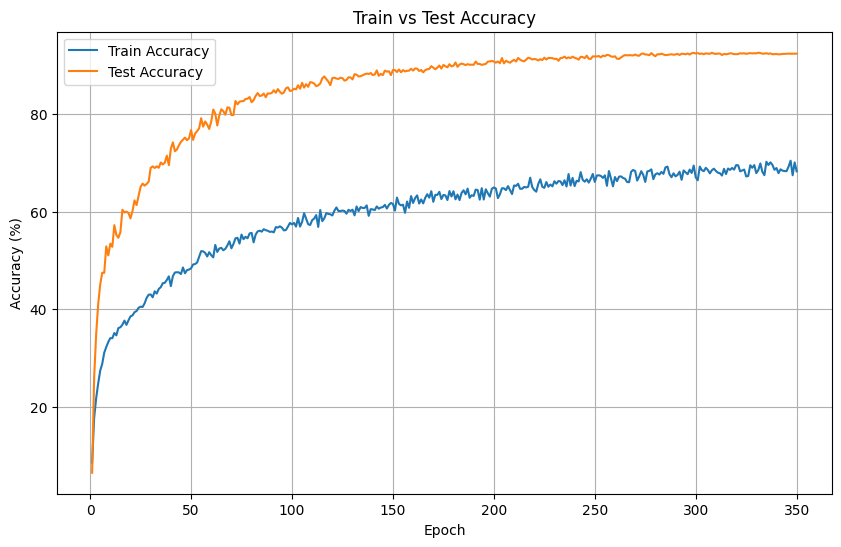

In [ ]:

import matplotlib.pyplot as plt
import torch

# Assuming train_accuracies and test_accuracies are lists of GPU tensors
train_accuracies_cpu = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracy_record]
test_accuracies_cpu = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in test_accuracy_record]

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies_cpu, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies_cpu, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_comparison.png')
plt.show()

# Testing





To test the trained model:


1. Ensure `model_checkpoint_epoch_350_local.pt` is in the same directory.
2. Run all cells to load the model and perform inference on test data.
3. The notebook will display test accuracy and visualize predictions on sample images.

100%|██████████| 170498071/170498071 [00:18<00:00, 9212976.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Accuracy: 99.59%
Test Accuracy: 92.33%


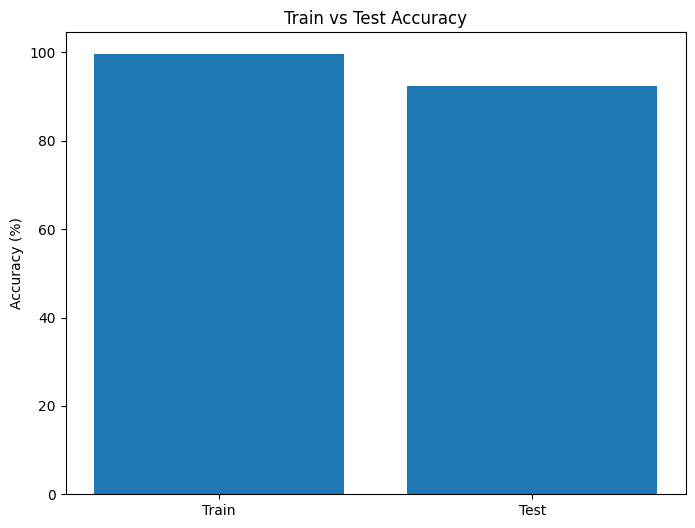

In [10]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Load the checkpoint, CHANGE THE PATH THAT TO WHERE THE MODEL IS AT
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/ kaggle input vit_cifar10_350th_epochs pytorch 350_epoch_vit_cifar10 1 /model_checkpoint_epoch_350_local.pt', map_location=device)


model = VisionTransformer().to(device)

#load the model
model.load_state_dict(checkpoint['model_state_dict'])


model.eval()


def compute_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100. * correct / total

# Compute train and test accuracies
train_accuracy = compute_accuracy(train_loader)
test_accuracy = compute_accuracy(test_loader)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy])
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.savefig('accuracy_comparison.png')
plt.show()



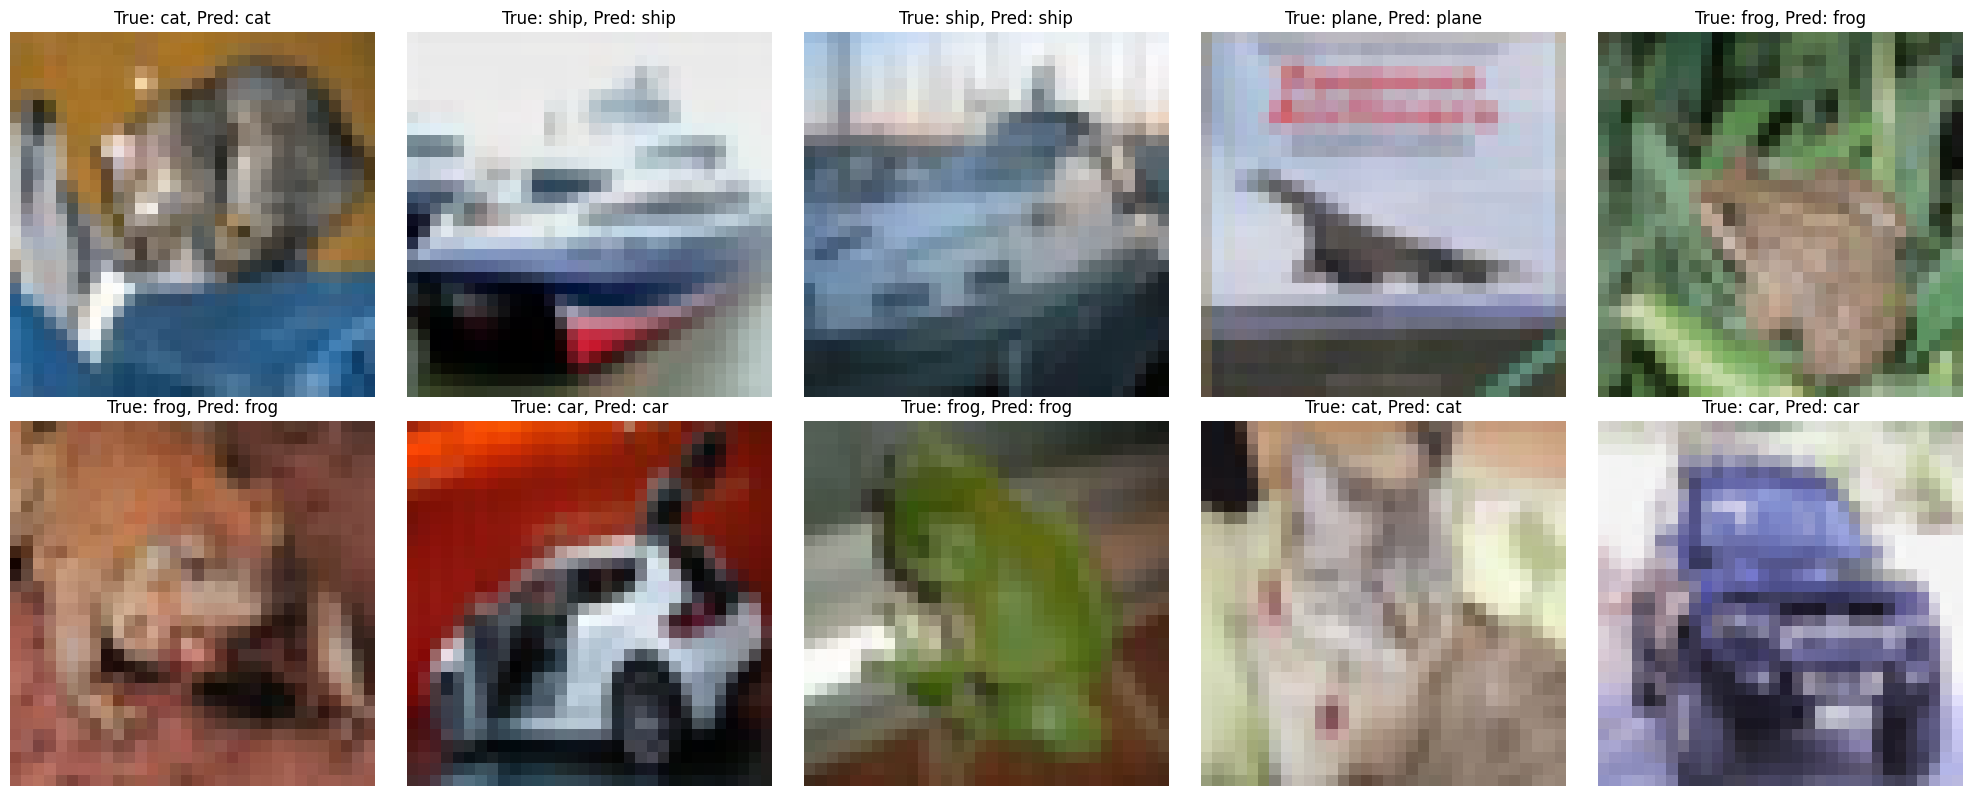

In [11]:

def show_prediction(ax, image, label, pred):

    image = image.cpu()

    # Reverse the normalization
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])
    image = image * std[:, None, None] + mean[:, None, None]

    # Clip the values to be between 0 and 1
    image = torch.clamp(image, 0, 1)

    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(f'True: {classes[label.item()]}, Pred: {classes[pred.item()]}')
    ax.axis('off')

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model.eval()
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i == 1:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        fig, axes = plt.subplots(3, 5, figsize=(20, 8))
        axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
        for j in range(15):
            show_prediction(axes[j], images[j], labels[j], predicted[j])
        plt.tight_layout()
        plt.show()